#### FINM 33150 - Regression analysis and quantitative trading strategies
<br>

## Quantitative Trading Project
<br>

### A k-means clustering pair selection approach for pairs trading
<br>

#### Author: Diego A. Diaz
#### Student ID: 12248985

<br>

#### Abstract

We develop a pair trading strategy that checks the displacement of prices of related electronically traded equities from multiple sectors and bets that the displacement will tend to reduce itself. This bet translates to a strategy of taking long positions on the equity with the lower returns and long positions on the equity with the higher returns, and repeating the same process for each pair. We propose a method of selecting pairs by applying an unsupervised machine learning method, K-means clustering, based on 5 variables of fundamentals from the Zacks Fundamentals Collection from Quandl and yearly returns from end of day prices, and later picking the 50 pairs with highest pearson correlations. After selecting pairs to trade, we implement a spread-reversion strategy that begins on the first day of each month, trades during the month, and closes positions at the end of each month if there are any open ones. We backtest the strategy from the start of 2019 to the end of 2020 and obtain a 6% return on investment per pair on average. In total we place 798 spread positions (one short and one long for each) among our pairs, and obtain a total sharpe ratio of -0.025. Average profit per pair was $3.759.

<br><br>
*Note*: We present our quantitative trading strategy in this Jupyter notebook, which includes the code to run to download the data and execute the strategy. Due to the long execution time of the data gathering process, we also include the data as a separate file along with this notebook, therefore allowing reviewers ir other researchers to execute backtests faster or try modifications of the strategy with the same or a selected subset of the pairs.
Only straighforward and function calls are included in this notebook, as the important mechanics of the strategy are included in the supplemental file **util.py**, which is imported in this notebook as a library. 

<br>

#### 1. Introduction

<br>

A pair trading strategy is well regarded by many hedge funds due to the fact that it's considered to be market neutral, which means that it can be expected to perform similarly and generate returns that are, to a large extent, independent of current market's trends. The key to the strategy is convergence in returns in selected pairs, which allows a trader to buy a relatively undervalued security and sell a relatively overvalued one for a profit upon convergence (Sarmento & Horta, 2020). One of the problems with more modern iterations of this strategy is that it has gotten progressively harder to find useful pairs, leading many researchers and traders to attempt to come up with data driven ways to select pairs, often borrowing methods from machine learning.

<br>

Before diving deeper into the details, to give some background about the strategy, it started being used in the mid-1980s by a group assembled by Wall Street quant Nunzio Tartaglia. Their programs identified pairs of securities that moved together, and a spread arbitrage strategy made their company $50 million dollars in profit in 1987 alone. In one of the seminal papers in the subject, Gatev et al. (2006), the authors backtest a simple pairs trading strategy with end of day equity prices through the period 1962-2002, choosing pairs of stocks by minimizing the distance between normalized historical prices. The authors examine the robustness of the results to a variety of risk factors like the bid-ask bounce, short-selling costs, and transaction costs. Although these factors affect the magnitude of the excess returns, their pair trading strategy remains profitable for reasonable assumptions in an out of sample period of 4 years.

<br>

There are many different approaches when it comes to choosing pairs for a pair trading strategy. Understanding the theory behind the strategy is necessary for choosing better performing pairs and increasing returns, and one of the key concepts is to view asset prices in relative terms and not as in absolute terms as a discounted future cash flow. In a relative pricing context, two securities that are close subtitutes for each other will sell for the same price, which led to develop the Law of One Price (LOP). The LOP states that two investments that have the same payoff in every possible state of nature, will have the same current value (Ingersoll, 1987). Sustained in the LOP, Gatev et al. (2006) set to find pairs that are "integrated" in the sense that they behave by the LOP, establishing the criterion that "they have had the same or nearly the same state prices historically". This approach translates into minimizing the historic sum of squared distances between two assets' price series. Mathematically, 

<br>

$$\overline{s s d}_{P_{i} P_{j}}=\frac{1}{T} \sum t=1^{T}\left(p_{i, t}-p_{j, t}\right)^{2}$$

<br>

Where $p_{i,t}$ is the price of asset $i$ at time $j$. A more modern approach to pair selection is the one implemented by Sarmento & Horta (2020), which is a principal component analysis (PCA) based on the price time series. In their paper, the authors focus on two issues. 1st: How to find profitable pairs while constraining the search space, and 2nd: How to avoid long decline periods due to prolonged divergent pairs. Although efforts in using machine learning techniques for pair selection have proved promising, they remain for the most part unexplored, and more research is still necessary to develop theories. The difficulty is in finding pairs without too much exposure to the adversities of the common pairs searching techniques. An alternative first step is to limit the universe of available stocks to securities within a sector, but that limits the availity to find stocks being traded in small volumes, reducing potential profits. Allowing for different sectors, the quantitative trader might be left with an excessive number of combinations and many spurious relations (Sarmento & Horta, 2020).

<br>

In this paper we apply an unsupervised machine learning method for pairs selection, starting from a broad universe of equities. We attempt to mix three different approaches from the literature. 1st, as in Sarmento & Horta (2020), we implement an unsupervised machine learning method for the selection of pairs, and do not limit the strategy to only look for pairs within the same sectors. We do however attempt a different machine learning method (K-means clustering instead of PCA) and use different data than the authors. 2nd, we use Pearson correlations as a selection metric to pick higher correlated pairs from the clusters. Using Pearson correlations for pair selection, without the previous ML step, is something that has been done by Chen et al. (2019). 3rd, we implement a standard mean reversion strategy as in Gatev et al. (2006), which can be summarized in the following steps:

1st: Calculate the pair's spread as $\left.S_{t}=Y_{t}-X_{t}\right)$ during the period. 
2nd: Define the model thresholds: the threshold that triggers a long position, $\alpha_{L}$, the threshold that triggers a short position, $\alpha_{S}$, and the exit threshold, $\alpha_{\text {exit }}$, that defines the level at which a position should be exited. 
3rd: iii Monitor the evolution of the spread, $S_{t}$, and control if any threshold is crossed. iv In case $\alpha_{L}$ is crossed, go long the spread by buying $Y$ and selling $X$. If $\alpha_{S}$ is crossed, short the spread by selling $Y$ and buying $X$. Exit position when $\alpha_{\text {exit }}$ is crossed.

<br>

The structure of the paper is as follows. In section 2 we explain the first step of the first selection process, a K-means approach to form clusters of equities. We show the entire process, from data gathering to algorithm implementation, finalizing with an output consisting of clusters of equities of any size. In section 3 we show and explain the next and final step in the pair selection process, based on Pearson correlation coefficients. In section 4 we develop our spread trading strategy with the selected pairs from the previous section. In section 5 we analyze our results and discuss. Section 6 concludes.

<br>

The steps of our quantitative trading strategy can be summarized in the following diagram:

<br>

![Steps in our quantitative trading strategy](steps_finm.png "Steps in our quantitative trading strategy")

<br>

<br>

#### 2. First step of pair selection: K-means clustering

<br>
<br>

K-means clustering is an unsupervised machine learning method of vector quantization. Unlabeled data is fed to a classifier that forms K different groups, to which each data point is then assigned such that each and every point belongs to a group. The objective of the algorithm is to reduce the total within-cluster variation, which means minimizing the distance from the points to the centroid of each cluster. 

<br>

The method starts by assigning each data point to a cluster, calculating the mean of these points (also called a centroid) and calculating the squared distances from each point to the mean. The process is iterated by reassigning points to other clusters until the within-cluster variation can not be reduced.

<br>

To apply the method we gather data from two different sources with the constraint that it is strongly dependent on at least one class of information besides prices, volumes and Fama-French factors. We opt to use fundamental data on different measures which we describe next:

<br>

**Source 1**: Zacks Fundamentals Collection from Quandl (ZACKS/FC) - This table contains over 200 fundamental indicators for over 19,500 companies, including over 9,000 delisted stocks. 

From ZACKS/FC we obtain 5 variables to feed to our algorithm. These are:

-  Total number of employees (emp_cnt)
-  Basic net earnings per share (basic_net_eps): Company's net earnings or losses attributable to common shareholders per basic share basis.
-  Earnings before interest, taxes, depreciation, and amortization (EBITDA): Income before interest, taxes, depreciation and amortization. 
-  Comprehensive income (compr_income)
-  Net income loss (net_income_loss)

<br>

**Source 2**: Zacks End of Day US Stock Prices (EOD). 

-  One year returns (calculated from daily closing prices)

<br>

**Approach:**

<br>

-  We obtain all US stocks traded in the NASDAQ and NYSE that have data for the 5 mentioned variables of ZACKS/FC. 
-  With this group, download EOD prices since december 2018 to the end of 2020, which will be our backtesting period. 
-  Estimate yearly returns of all stocks in group and join with ZACKS/FC data, obtaining a matrix with 6 variables: employees, eps, ebitda, income, income loss, and yearly returns.
-  Form clusters with K-mean clustering. We have to pick the K number of clusters un this step, for which we pick 1000 clusters.



#### 2.1 Code section: Getting Zachs data

<br>

We write several helper functions to download the data. Zachs fundamental data come from quarterly and annual reports. In order to make sure we get data for the most amount of companies as possible, we download all quarterly reports for a given year and the anual report and calculate the averages of each variable, obtaining one value for each variable for each company. We only keep tickers that have values for all 5 variables after taking averages.

Note: We put the source code on the attached file **util.py**, which contains helper functions and classes necessary to execute the trading strategy in this notebook. The code sections on this technical paper contain a minimum amount of source code but what we expect is enough to understand what it is we are doing so the reader can check the supplemental material if he or she wants to know more.

For each section of code that the reader wants to review, go to the corresponding section in **util.py**, which follows the same section numbering.

<br>


#### We import the libraries that we will need to execute the code in this notebook:

In [696]:
%matplotlib inline
from util import *

Next block downloads Zachs data but takes several minutes to execute.

Note that we add progress bars to keep track of the progress to check if we need to interrupt processes.

In [663]:
data_zachs = execute_zachs_download()
data_zachs

  0%|          | 0/38 [00:00<?, ?it/s]

,AA,AAL,AAME,AAOI,AAP,AAPL,AAT,AAWW,ABB,ABBV,ABC,ABEV,ABG,ABIO,ABMD,ABR,ABT,ABUS,AC
zacks_sector_code,7.000,15.000,13.0000,10.0000,3.00000,10.000,13.0000,15.00000,7.000,4.000,4.00000,1.000000,3.00000,4.00000,4.0000,13.0000,4.00,4.0000,13.0000
emp_cnt,14600.000,103100.000,159.0000,3054.0000,71000.00000,132000.000,194.0000,2870.00000,134800.000,29000.000,21000.00000,51432.000000,8000.00000,20.00000,1143.0000,445.0000,99000.00,130.0000,71.0000
basic_net_eps,0.222,1.362,0.0520,0.8980,2.79000,1.199,0.2100,3.89200,0.418,1.628,3.04200,0.070000,3.01000,-9.24468,1.3600,0.5080,0.15,-0.6140,0.0560
ebitda,900.400,1794.400,6.8626,29.4358,333.34764,32720.400,73.7534,189.02034,1134.600,4668.800,805.39132,2454.299800,141.09988,-5.80600,73.9150,71.1254,2419.00,-28.6650,-7.0264
compr_income,-4920.200,-5174.000,0.5386,8.4064,-29.34340,-2784.800,12.7750,-4.22380,-4475.400,-2656.400,-76.07400,-20080.966667,0.82000,-0.00200,-8.3004,0.0880,-6355.80,-48.1874,6.7120
net_income_loss,538.600,512.800,0.2576,33.3196,342.54080,43684.000,20.2576,101.29040,1720.000,5136.000,1331.90760,1825.218420,105.84000,-10.20200,105.9844,78.5742,847.40,-47.8808,-6.2488


In [429]:
data_zachs.shape

(6, 2390)

As we can see, we get data for 2390 different equities from Zachs/FC.

Code is included in the source code to save and load the data for faster access to avoid running repeatedly the parts of the code that take longer to execute.

In [676]:
#we load the pickle of zachs data in case we are working on a different session
#run this block if you want to access the data without downloading with execute_zachs_download() 
data_zachs = load_zachs()

#### 2.2 Code section: Download daily close prices to get returns

Next we download code to download daily equity closing prices for all equities available from previous step (equities with Zachs fundamental data)

In [666]:
# This blocks downloads the data, takes several minutes to download all 2390 equities.
prices = get_prices(data_zachs.columns)

  0%|          | 0/18 [00:00<?, ?it/s]

In [433]:
prices.shape

(524, 2390)

As we can see, we obtained data for all 2390 equities that we had from the previous step.

In [677]:
#we load the pickle of EOD data in case we are working on a different session
#run this block if you want to access the data without downloading
prices = load_prices()

The final data processing step in this section is to add yearly returns, for which we use one of our helper funtions. 

In [678]:
final = combine_zachs_prices(data_zachs, prices)
final

,AA,AAL,AAME,AAOI,AAP,AAPL,AAT,AAWW,ABB,ABBV,...,ZEPP,ZG,ZGNX,ZKIN,ZLAB,ZNGA,ZNH,ZTO,ZTS,ZYME
zacks_sector_code,7.000000,15.000000,13.000000,10.000000,3.000000,10.000000,13.000000,15.000000,7.000000,4.000000,...,4.000000,10.000000,4.000000,6.000000,4.000000,2.000000,15.000000,15.000000,4.000000,4.000000
emp_cnt,14600.000000,103100.000000,159.000000,3054.000000,71000.000000,132000.000000,194.000000,2870.000000,134800.000000,29000.000000,...,416.000000,3181.000000,68.000000,377.000000,88.000000,1555.000000,96234.000000,16023.000000,9200.000000,147.000000
basic_net_eps,0.222000,1.362000,0.052000,0.898000,2.790000,1.199000,0.210000,3.892000,0.418000,1.628000,...,0.228000,-0.208000,-1.720000,0.520000,-2.320000,0.012000,2.406667,0.314000,0.832000,-0.172000
ebitda,900.400000,1794.400000,6.862600,29.435800,333.347640,32720.400000,73.753400,189.020340,1134.600000,4668.800000,...,41.068750,-14.646400,-53.089200,10.025400,-50.920900,21.377400,1434.251333,263.008620,822.200000,-2.279800
compr_income,-4920.200000,-5174.000000,0.538600,8.406400,-29.343400,-2784.800000,12.775000,-4.223800,-4475.400000,-2656.400000,...,8.546333,-1.318000,-0.046000,-0.127500,0.449900,-92.141000,0.000000,-20.397800,-520.200000,-6.659000
net_income_loss,538.600000,512.800000,0.257600,33.319600,342.540800,43684.000000,20.257600,101.290400,1720.000000,5136.000000,...,10.272200,-50.258200,-88.902400,7.101550,-50.384100,15.696600,437.784000,194.206000,777.000000,-22.984600
year_returns,-0.380031,-0.304437,-0.412334,-0.515292,-0.142596,0.458624,0.162291,-0.547872,0.148198,-0.021511,...,0.039269,0.113903,0.051927,-0.351759,1.054918,0.709589,-0.123266,0.219388,0.291801,2.269891


Missing data was removed when consolidating the data, which is why 32 equities were lost. Total number of equities is now 2358.

#### 2.3 Code section: K-means clustering


Here we implement a K-means clustering algorithm to form clusters of similar stocks based on the gathered data. Note that we included sector code in the data above, however, we don't include it when performing the clustering as it is a categorical variable and do not needed to apply the algorithm. 

We show the 10 clusters with the highest number of stocks in them. 


In [685]:
df, cluster_counts = kmeans_clustering(final)

848    78
578    51
368    51
851    46
134    40
502    30
834    29
571    26
513    26
656    26
Name: Clusters, dtype: int64


Next, we form every possible pair with equities within each cluster, leaving out clusters that have less than 2 equities as we can't form pairs with them.

In [687]:
pairs = get_combinations_of_pairs(cluster_counts, df)
pairs[:10]

  0%|          | 0/273 [00:00<?, ?it/s]

[('ABIO', 'ACET'),
 ('ABIO', 'ACTG'),
 ('ABIO', 'AKTX'),
 ('ABIO', 'ALBO'),
 ('ABIO', 'ALDX'),
 ('ABIO', 'ALRN'),
 ('ABIO', 'APTO'),
 ('ABIO', 'AVCO'),
 ('ABIO', 'AVEO'),
 ('ABIO', 'AZRX')]

In [691]:
len(pairs)

14838

(Note that we can get slightly different clusters and number of pairs on different executions)

In [771]:
#only execute this code if you need to load the pairs
#pairs = load_pairs()

<br>

#### 3. Second step of pair selection: Pearson correlation coefficient sorting

<br>
<br>

On their paper, Chen et al. (2017) backtested a pair trading strategy in which they chose 50 pairs with the highest Pearson correlation coefficients from historical returns. They identified stocks that tended to move closely in a period of 5 years and checked if price divergences on a given month were closed in the future, as their trading strategy was executed on a monthly basis. The authors found that betting on the convergence generates six-factor (market, size, book-to-market, momentum, short-term reversal, and liquidity) alphas of up to 9% annually for a value-weighted self-financing portfolio. 

In this section we incorporate the authors approach to pair selection to complement our machine learning approach, picking pairs with the highest Pearson correlations out of the clusters obtained by K-means clustering.

<br>


#### 3.1 Code section: Calculating Pearson coefficient

From the previous step, we have 14,838 potential pairs to trade. This is too many, even more so considering that trading one pair means to be ready to take both a long and short position at the same time, so if we traded 14,838 pairs, the maximum amount of opened positions at any one time would be 29,676.

After ranking the pairs we will keep drop the ones whose Pearson coefficient is too high (above 0.95), as that happens usually when we have tickers that represent different class of shares by same company and may have trading restrictions that we haven't accounted for.

After that, following Chen et al. (2017), we will keep the 50 pairs with higher Pearson coefficients to continue with our trading strategy.

<br>


In [693]:
df = calculating_pearson(prices, pairs)
df.head()

  0%|          | 0/14838 [00:00<?, ?it/s]

,pair,pearson_corr
0,"(ABIO, ACET)",-0.013173
1,"(ABIO, ACTG)",0.016995
2,"(ABIO, AKTX)",-0.004648
3,"(ABIO, ALBO)",0.047083
4,"(ABIO, ALDX)",0.129323


In [694]:
print(df.sort_values('pearson_corr', ascending=False)[:10])

                 pair  pearson_corr
14807   (GOOG, GOOGL)      0.997364
14405         (Z, ZG)      0.994611
14667  (DISCA, DISCK)      0.984691
14676  (LBTYA, LBTYK)      0.984199
14766       (UA, UAA)      0.982237
14748     (NWS, NWSA)      0.977505
14266   (CENT, CENTA)      0.977240
14513  (FWONA, FWONK)      0.973279
13960     (OHI, SBRA)      0.893488
14547      (CPT, UDR)      0.892413


As the first 8 values are stock of the same companies. For example, GOOG and GOOGL are both Google, with the only difference that the GOOG ticker symbol is associated with class C shares, which means that GOOGL shares have voting rights, while GOOG shares don't have any voting rights.

We drop the pairs with Pearson coefficients above 0.95 and keep the first 50 pairs after that.

<br>

In [695]:
selected_pairs = sort_and_select_pairs(df)
selected_pairs[:5]

,pair,pearson_corr
13960,"(OHI, SBRA)",0.893488
14547,"(CPT, UDR)",0.892413
14806,"(VIAC, VIACA)",0.891144
14747,"(MLM, VMC)",0.887336
12966,"(AKR, KRG)",0.882830


<br>

#### 4. Spread trading strategy

<br>

To get trading signals we implement a strategy as in Gatev, Goetzmann, & Rouwenhorst (2006) or as in FINM 33150, Spread Trading assignment, and backtest it in the period 2019-2020. The strategy is simple and consists in the steps outlined in the introduction. We also add a stop loss for each spread position. In more detail, we follow each of the next steps per each pair of the 50 that we got from the previous step: 

<br>

- Calculating m-day returns for each equity 
- Estimating the pair spread $\left.S_{t}=Y_{t}-X_{t}\right)$
- Define the thresholds: the threshold that triggers a long position, $\alpha_{L}$, the threshold that triggers a short position, $\alpha_{S}$, and the exit threshold, $\alpha_{\text {exit }}$, that defines the level at which a position should be exited. For easier implementation we confine our parameters to $\alpha_{s} = -\alpha_{L}$.
- Monitor if the threshold is crossed. When $\alpha_{L}$ is crossed, go long the spread by buying $Y$ and selling $X$. If $\alpha_{S}$ is crossed, short the spread by selling $Y$ and buying $X$. Exit position when $\alpha_{\text {exit }}$ is crossed.
- Monitor if a stop loss is triggered, defined as a fraction of the position. We'll call this parameter $\delta$. 

<br>

To determine quantities to trade we estimate daily dollar volume for each equity, compute the running trailing 15-trading-day median of it over our sample period for $X$, and denote that running median (as of any day given $t$ ) for the less liquid of the two ETFs with the expression $N_{t}$.

<br>

$$
N_{t}:=\operatorname{Median}\left[\left\{V_{t-16}, V_{t-15}, \ldots, V_{t-1}\right\}\right]
$$

<br>

As in FINM 33150 Assignment 2, our strategy trades equal dollar amounts of $X$ and $Y$ to the nearest integer number of shares, as close as possible to $\$ N_{t} / 1000$ of each. As $N_{t}$ changes every day, so trade size will depend on which day you open the position. Gross traded cash per pair is therefore roughly $\$ 2 N_{t} / 1000 .$ We track this number on any open position for stop loss calculations.

We set the capital for the strategy to the maximum $\frac{N_{t}}{50}$ per pair during the data period. Therefore the total capital will be equal to $ \sum_{n=1}^{50} \frac{N_t}{50} $.

As there is so much variation from the pair selection part of the strategy, we focus on a fix parameter space, choosing the following values for the parameters:

- $m\ days = 1$
- $\alpha_{L} = - \alpha_{L} = 0.02$
- $\alpha_{exit} = 0.001$
- $\delta = 0.25$

Our strategy will begging at the first day of each month, trade during the month, and close any open positions at the end of the month. Since we backtest all through 2019 and 2020, the first possible day for a trade is January 1, 2019, and the last possible day to close a trade is December 31, 2020. We do not allow for more than 1 spread position for each pair, and in case a stop loss is triggered, we don't allow to enter new positions until the start of the next month.

<br>

#### 4.1 Code section: Implementing the spread trading strategy for a single pair

<br>

We write several helper functions to download closing day prices for the equities in our pairs from Quandl EOD, estimate m-day log returns, process volumes to determine amount to trade, a spread trading class that will take care of the trading mechanics and keep track of the profits and open positions, functions to determine the first and last day of the month, and functions to calculate the spread of returns for each pair. We also include functions to plot the results and cumulative profit and loss.

As in previous sections, we include the source code in the supplemental material and call the functions required to show results here. 

In case the data for our pairs is not loaded, we load it in the next block:

<br>

In [3]:
#save_selected_pairs(selected_pairs)
selected_pairs = load_selected_pairs()

Let's take a look at the spread for the first pair to make sure our calculations are going as expected. Note that we keep track of whether we are on the firs/last day of the month as this is necessary for our trading strategy.

In [697]:
df_spread = example_spread_calculation(selected_pairs)
df_spread[18:21]

,spread,N,OHI,SBRA,first_day,last_day
Date,,,,,,
2018-12-31,-0.005435,30184459.52,29.200633,13.443808,False,True
2019-01-02,-0.009542,27898112.14,28.203741,13.109344,True,False
2019-01-03,-0.024504,27898112.14,28.685572,13.664064,False,False


Let's execute the strategy for the first pair:

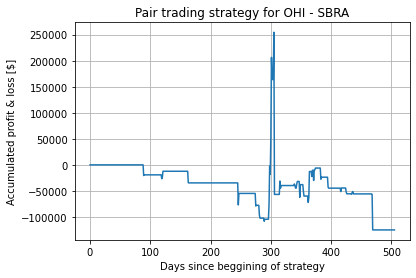

In [704]:
list_of_pairs = list(selected_pairs['pair'])
pnl, roi = trade_example_pair(list_of_pairs[0])

As we can see, a trading strategy based on the pair OHI-SBRA (real state investment companies) doesn't perform well over the backtesting period, leading to a lost of $125.000 dollars and a return of investment of:

In [706]:
print('{:.01%}'.format(roi))

-4.5%


<br>

#### 4.2 Code section: Implementing the spread trading strategy for all pairs

<br>

We are finally ready to apply our trading strategy to all pairs. We do this by iterating through our list of 50 pairs, keeping track of progress with a progress bar and saving all results. Note that in my computer the strategy takes about a second to run per pair.

<br>

  0%|          | 0/50 [00:00<?, ?it/s]

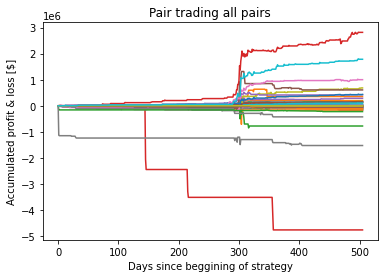

In [711]:
results, rois, capital = trade_all_pairs(list_of_pairs)
number_of_trades = plot_all_pairs_pnl(results, pairs)

<br>

#### 5. Results of strategy and discussion

<br>

In this section we obtain and analyze results from our trading strategy, providing a brief discussion of possible variations that could be implemented.

Let's start by looking at the total number of trades executed in the entire period.

<br>

In [712]:
print(sum(number_of_trades))

798


A total of 798 trades were executed in the period 2018-2019. Note that these are spread positions, so each one includes a long and a short position. 

<br>

#### 5.1 Trading patterns and profit and loss

<br>

Let's take a look at the number of spread positions placed per pair.

<br>

In [713]:
selected_pairs['times traded'] = number_of_trades
selected_pairs

,pair,pearson_corr,times traded
13960,"(OHI, SBRA)",0.893488,25
14547,"(CPT, UDR)",0.892413,6
14806,"(VIAC, VIACA)",0.891144,15
14747,"(MLM, VMC)",0.887336,3
12966,"(AKR, KRG)",0.882830,8
13959,"(NNN, STOR)",0.874091,1
14726,"(BRX, REG)",0.873674,15
11583,"(INN, XHR)",0.864441,20
13604,"(BDN, PGRE)",0.853241,14
11623,"(PEB, XHR)",0.849437,8


We can see that we are trading each pair a considerable amount of time during the two years in which we backtest the strategy. Let's take a look at some descriptive statistics about the trading behavior:

In [714]:
selected_pairs.describe()

,pearson_corr,times traded
count,50.000000,50.000000
mean,0.807051,15.960000
std,0.044795,13.286421
min,0.742877,1.000000
25%,0.769397,7.000000
50%,0.800250,12.000000
75%,0.837063,21.750000
max,0.893488,57.000000


We can see that on average we are trading each pair almost 16 times. On the pair we trade the least amount of times we only take 1 position, which happens for the pair (NNN, STOR), and the pair we trade the most is (INN, ROIC), which we trade a total of 57 times.

Now we can look at how many trades we have open at the same time:

<br>

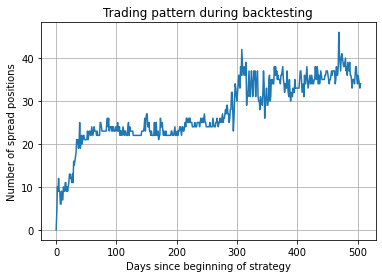

In [716]:
open_trades = count_and_plot_open_trades(results, list_of_pairs)

In [717]:
open_trades.sum(axis=1).mean()

27.385375494071145

It is interesting to see that our average number of opened spread positions is slightly above 27, which means that on a random day we are holding positions (either long or short) on over 54 equities on average. 

Let's take a look at the most important result of the strategy, that is, the aggregated profit and loss:

<br>

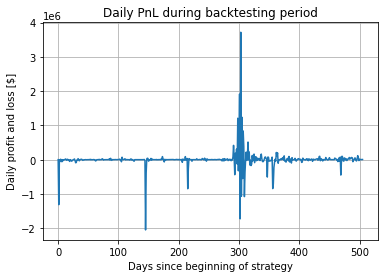

In [718]:
total_pnl = calculate_total_daily_pnl(results, list_of_pairs)

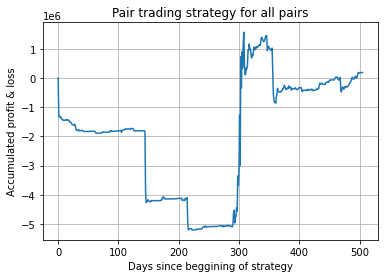

In [723]:
aggregated_pnl = get_aggregated_pnl(total_pnl)

Let's take a look at the total profit from each pair during the whole backtesting period.

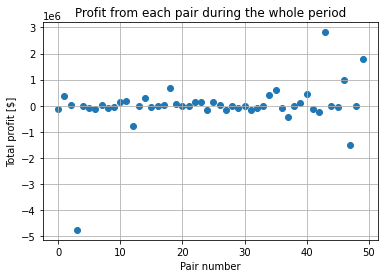

In [737]:
total_pnl = scatter_pnl(results)

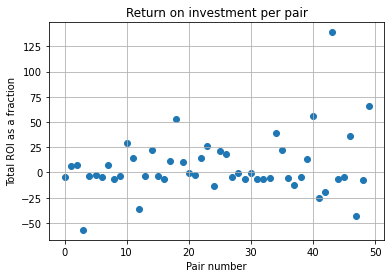

In [749]:
total_roi = scatter_roi(rois)

We can count the amount of pairs that are profitable and unprofitable, obtaining that 20 pairs are profitable during the period and 30 are unprofitable.

In [738]:
print(count_profitable_pairs(total_pnl))

20


In [769]:
print('Pair with minimum ROI achieved a ROI of: ' + str(min(rois)))

Pair with minimum ROI achieved a ROI of: -56.934469481792604


In [770]:
print('Pair with maximum ROI achieved a ROI of: ' + str(max(rois)))

Pair with maximum ROI achieved a ROI of: 138.930396725871


Regarding return on investment, we calculate the average among our 50 pairs. The average return on investment is 6.126% during our backtesting period.

In [754]:
sum(total_roi)/len(total_roi)

6.12596003929468

#### 5.2 Code section: Total daily returns of strategy, sharpe ratio and comparison to Fama-french factor returns

We add the initial capital to the strategy to calculate overall returns and get more useful performance metrics.

We start by looking at the returns of the strategy during a few days.

In [725]:
df_returns = get_strategy_returns(new_list, capital)
df_returns[5:9]

,Strategy Returns
5,-0.008441
6,0.000310
7,-0.007825
8,-0.000111


Let's also take a look at summary statistics, including annualized return, skewness, kurtosis, cornish-fisher approximation, sharpe ratio, and maximum drawdawn.

In [726]:
summary_stats(df_returns)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Strategy Returns,0.011132,0.746359,6.798316,111.823205,-0.158441,0.078679,-0.024505,-0.551891


#### 5.1 Comparison with Fama-French factor returns

<br>

We obtain Fama-French factor returns during the same period of our backtest to compare with our strategy.



In [727]:
ols_res = ols_regression_ff(df_returns)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     101.7
Date:                Sun, 30 May 2021   Prob (F-statistic):           2.08e-51
Time:                        02:23:28   Log-Likelihood:                -1844.5
No. Observations:                 505   AIC:                             3697.
Df Residuals:                     501   BIC:                             3714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5977      0.420      1.425      0.1

Inferences from the regression:
>- Alpha is negative with annualized returns of 0.01.
>- Beta is negative for Market portfolio. Based on the p-value, we can reject the null hypothesis that this factor loading is 0 at 1%.
>- We can reject the null hypothesis that the factor High minus low is zero as the value premium has a negative correlation with our strategy.
>- The strategy has no or little correlation with small caps, as we can not reject the null hypothesis that this factor is different from zero. 

<br>

#### 6. Conclusion

<br>

In this paper we attempted to extend the results of Gatev et al (2006) by implementing a pairs trading strategy. In line with some of the modern literature on machine learning methods for pairs trading that uses DBSCAN or PCA as Sarmento & Horta (2020). We applied K-means clustering to form groups of similar stocks by taking all the stocks from the NASDAQ and the NYSE, gathering a combination of fundamental and returns data, and applying the algorithm to form 1000 clusters from a group of 2358 stocks. Within each cluster of stocks, we formed all possible combination of pairs, obtaining 14,838 pairs. We ranked all of them according to the Pearson coefficient of their stocks and selected the 50 pairs with higher coefficients after dropping pairs that were almost identical. This last step is in line with work by Chen et al. (2019).

Our strategy selected pairs heavily concentrated in real state investments and produced barely profitable results during the two-year period in which we analyzed it. We calculated the sharpe ratio of the overall strategy, obtaining a negative value of -0.025 and annualized returns of 1.1%. Out of the 50 considered pairs, 20 produced positive returns, and average return on investment per pair was 6.1%. Average total profit per pair was $3.759. 

We stayed within our capital constraints at all times and only traded a small volume of the daily total for each equity. To achieve this, we followed the approach from the FINM 33150 Spread Trading assignment, computing the 15-trading-day median of daily dollar volume for the least liquid equity in each pair, $N_t$, and traded and amount equal to $N_t$ each time that our trading signal was triggered. The amount of trading incurred in our strategy was significant, averaging slightly above 27 open spread positions each day.

Given the low yearly returns and high drawdown of -55\% of our strategy, we can not recommend it for investment at the moment. The pairs selected by the strategy, although on average obtained positive returns, are not ideal as some of them incurred on excessive negative returns due to having higher traded volumes. The range of returns on our investments considering our 50 pairs were between -57\% to 139\%.

As future lines of research, we suggest adding more sources of alternative data to study the variation in pair selection achieved by K-means clustering, as well as considering more parameter values in order to optimize the threshold values for taking a short and long position, and the threshold value for closing positions.

<br>

#### 7. References

<br>

Gatev, E., Goetzmann, W. N., & Rouwenhorst, K. G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. The Review of Financial Studies, 19(3), 797-827.

<br>

Sarmento, S. M., & Horta, N. (2020). Enhancing a Pairs Trading strategy with the application of Machine Learning. Expert Systems with Applications, 158, 113490.

<br>

Navghare, N. D., Kulkarni, H. P., Kedar, P. R., Thakre, S. A., & Patil, P. S. (2020, July). Design of Pipeline Framework for Pair Trading Algorithm. In 2020 Second International Conference on Inventive Research in Computing Applications (ICIRCA) (pp. 630-635). IEEE.

<br>

Ingersoll, J. E. (1987). Theory of financial decision making (Vol. 3). Rowman & Littlefield.

<br>

Chen, H., Chen, S., Chen, Z., & Li, F. (2019). Empirical investigation of an equity pairs trading strategy. Management Science, 65(1), 370-389.
